# Objectives
>The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:
>
> 1. Predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
>
> 2. Identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.


>  _Import required libraries_

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',230)
pd.set_option('display.max_rows',20)


> Generic Function to identify and plot missing values


In [2]:
def plot_missing_values(df,fig_x,fig_y):
    # check null value
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_values_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    missing_values_df.sort_values('percent_missing', inplace=True, ascending=False)
    missing_values_df = missing_values_df[missing_values_df.percent_missing > 0]
    if len(missing_values_df) > 0:
        plt.figure(figsize=(fig_x,fig_y))
        sns.barplot(x = 'percent_missing',y = 'column_name',data = missing_values_df)
        plt.show()
    else:
        print("No data available")
        
        
def model_metrics(matrix) :
    TN = matrix[0][0]
    TP = matrix[1][1]
    FP = matrix[0][1]
    FN = matrix[1][0]
    accuracy = round((TP + TN)/float(TP+TN+FP+FN),3)
    print('Accuracy :' ,accuracy )
    sensitivity = round(TP/float(FN + TP),3)
    print('Sensitivity / True Positive Rate / Recall :', sensitivity)
    specificity = round(TN/float(TN + FP),3)
    print('Specificity / True Negative Rate : ', specificity)
    precision = round(TP/float(TP + FP),3)
    print('Precision / Positive Predictive Value :', precision)
    print('F1-score :', round(2*precision*sensitivity/(precision + sensitivity),3))



> #### Load the CSV file

In [109]:
df_sample = pd.read_csv("sample.csv")
df_sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


> #### Load the training set


In [110]:

pd.options.mode.chained_assignment = None  # default='warn'
df_train = pd.read_csv("train.csv")
df_train.head(5)



,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [111]:

df_test = pd.read_csv("test.csv")
df_test.head()


,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

> Check whether churn probability col exists in test data     

In [112]:
for col in df_train.columns:
    if col not in df_test.columns:
        print(col)
 

churn_probability


## _Data Cleaning_

> check null values

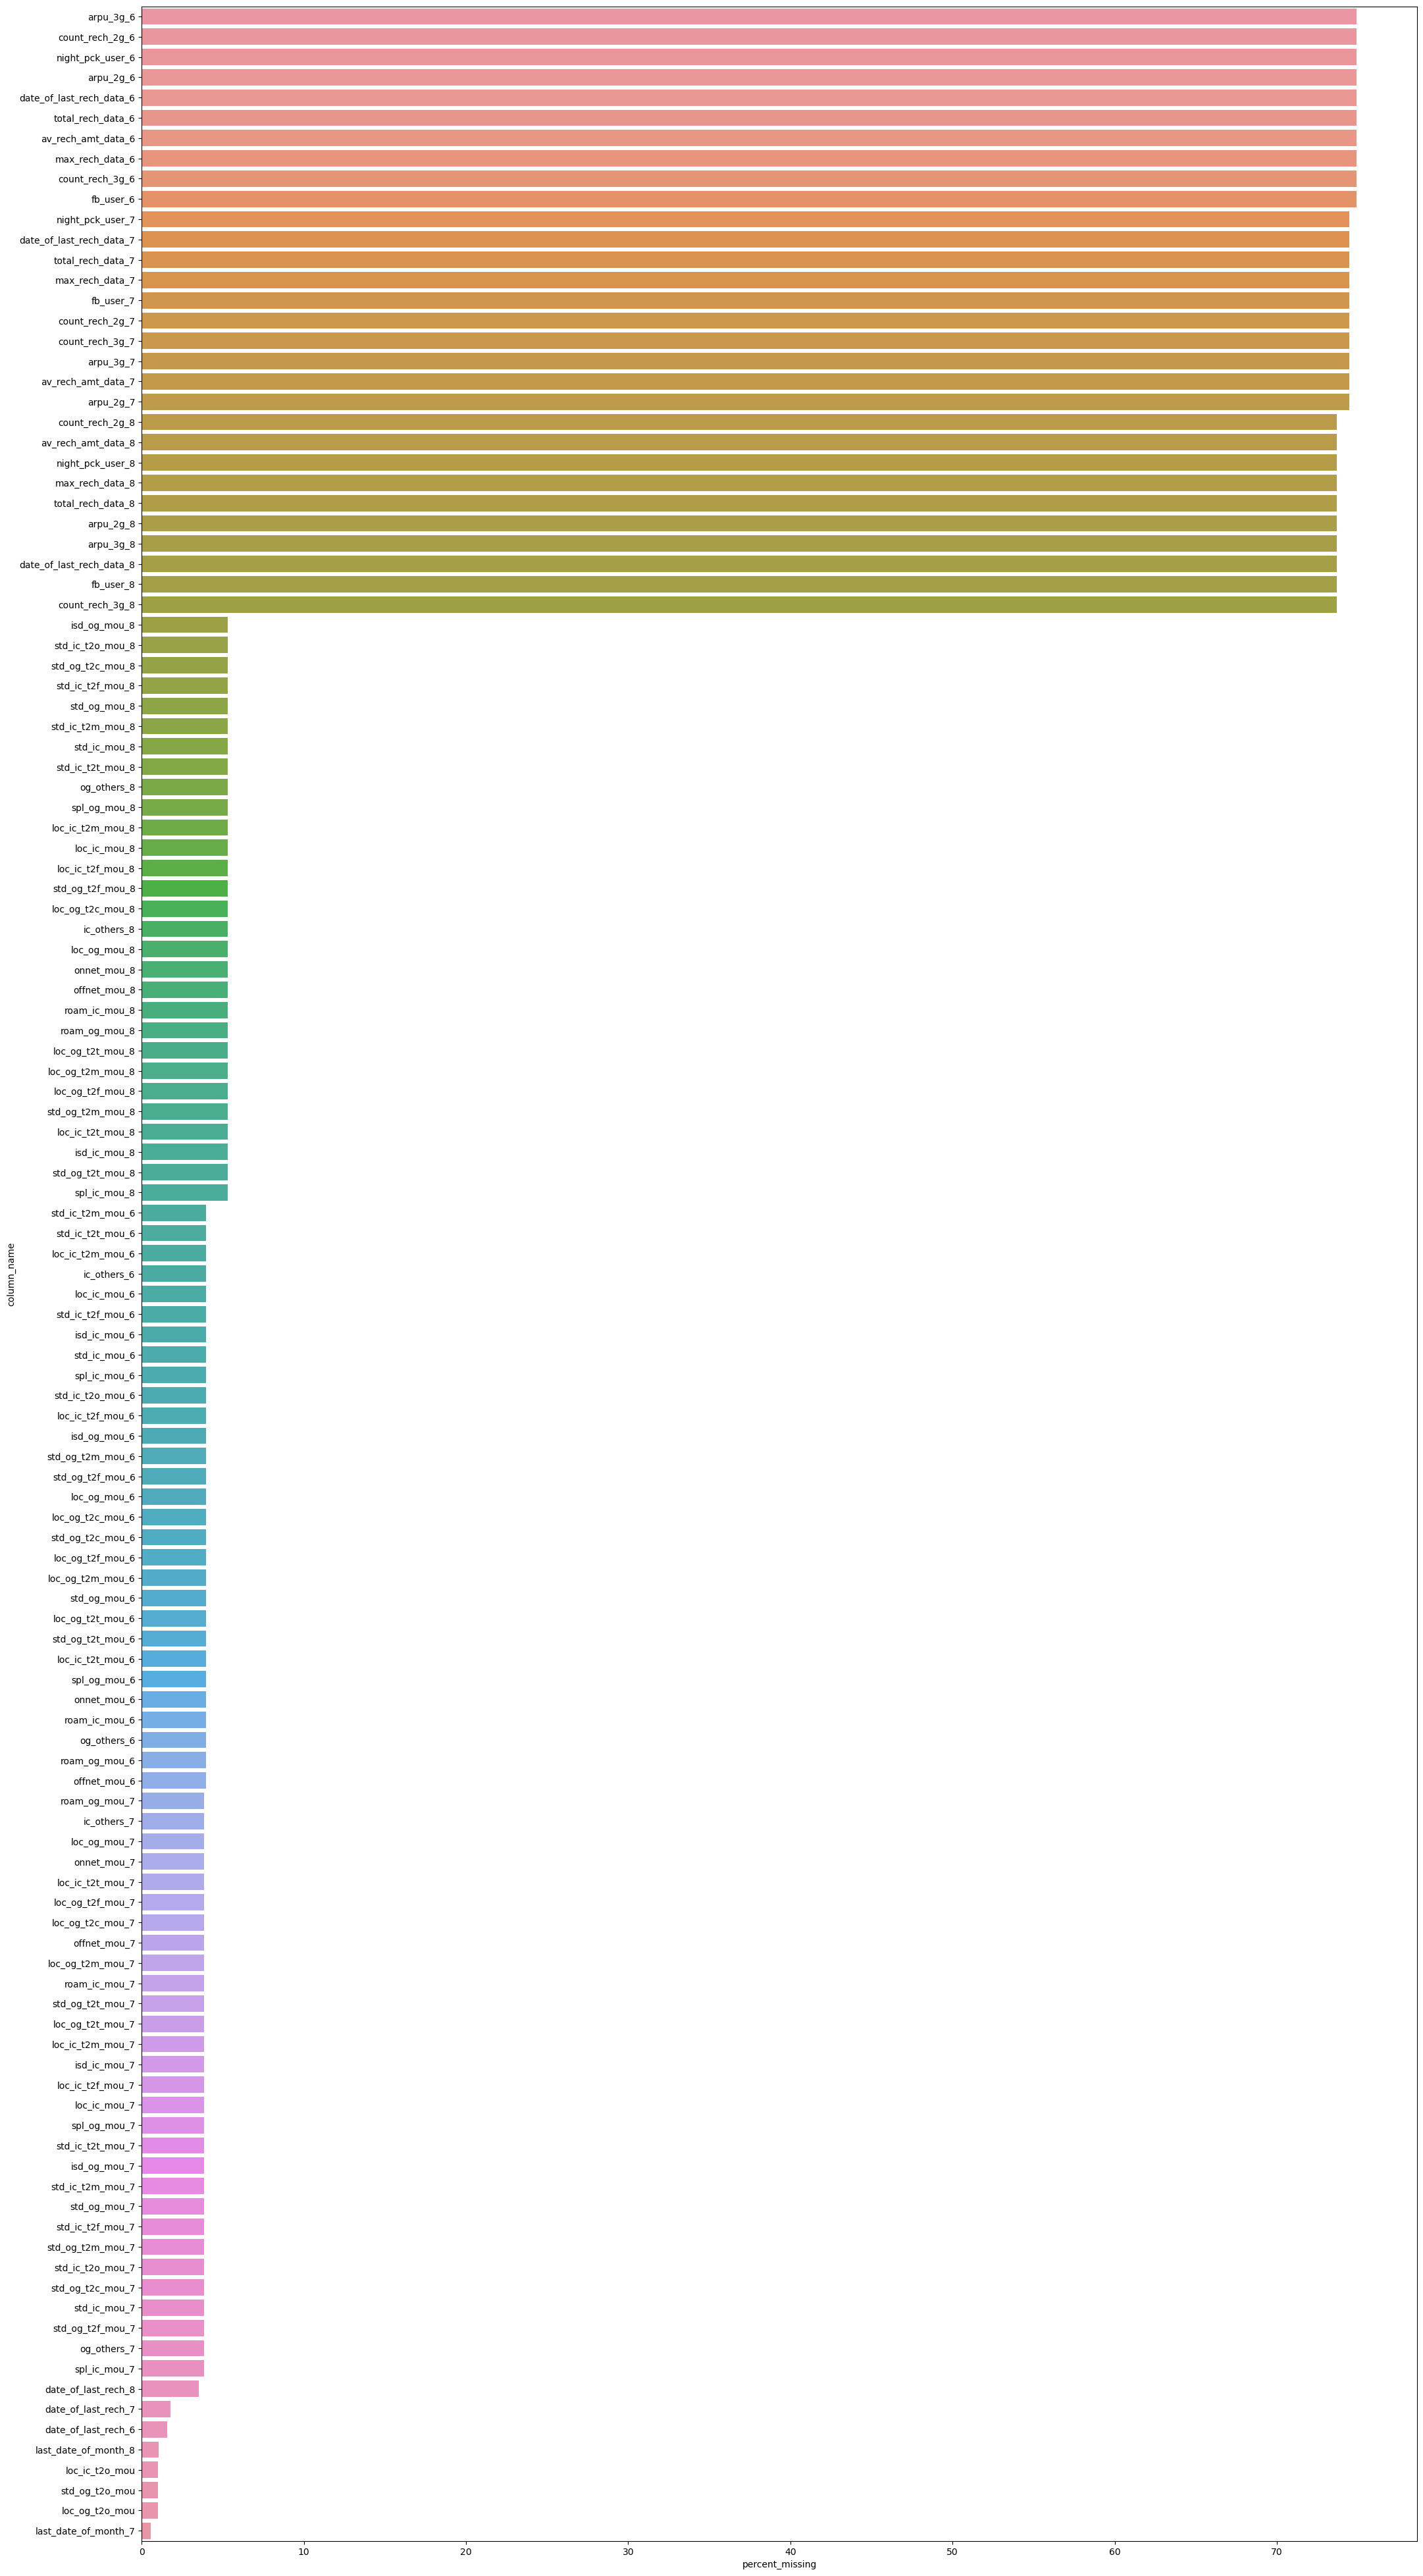

In [7]:

plot_missing_values(df_train,25,50)


> Function to impute values 

In [113]:

def impute_columns (df, imputes=False, mising_columns=False):
    # Function impute the nan with 0
    # argument: colList, list of columns for which nan is to be replaced with 0
    if imputes:
        for col in [impute + suffix for suffix in ['_6','_7','_8'] for impute in imputes]:
            df[col].fillna(0, inplace=True)
    else:    
        for col in mising_columns:
            df[col].fillna(0, inplace=True)




> Business Related Columns , we need to impute these , rather than drop the columns

In [114]:
 
biz_columns = ['arpu_3g','count_rech_2g','night_pck_user','arpu_2g','total_rech_data','av_rech_amt_data','max_rech_data','count_rech_3g','fb_user']
impute_columns(df_train,biz_columns)
impute_columns(df_test,biz_columns)

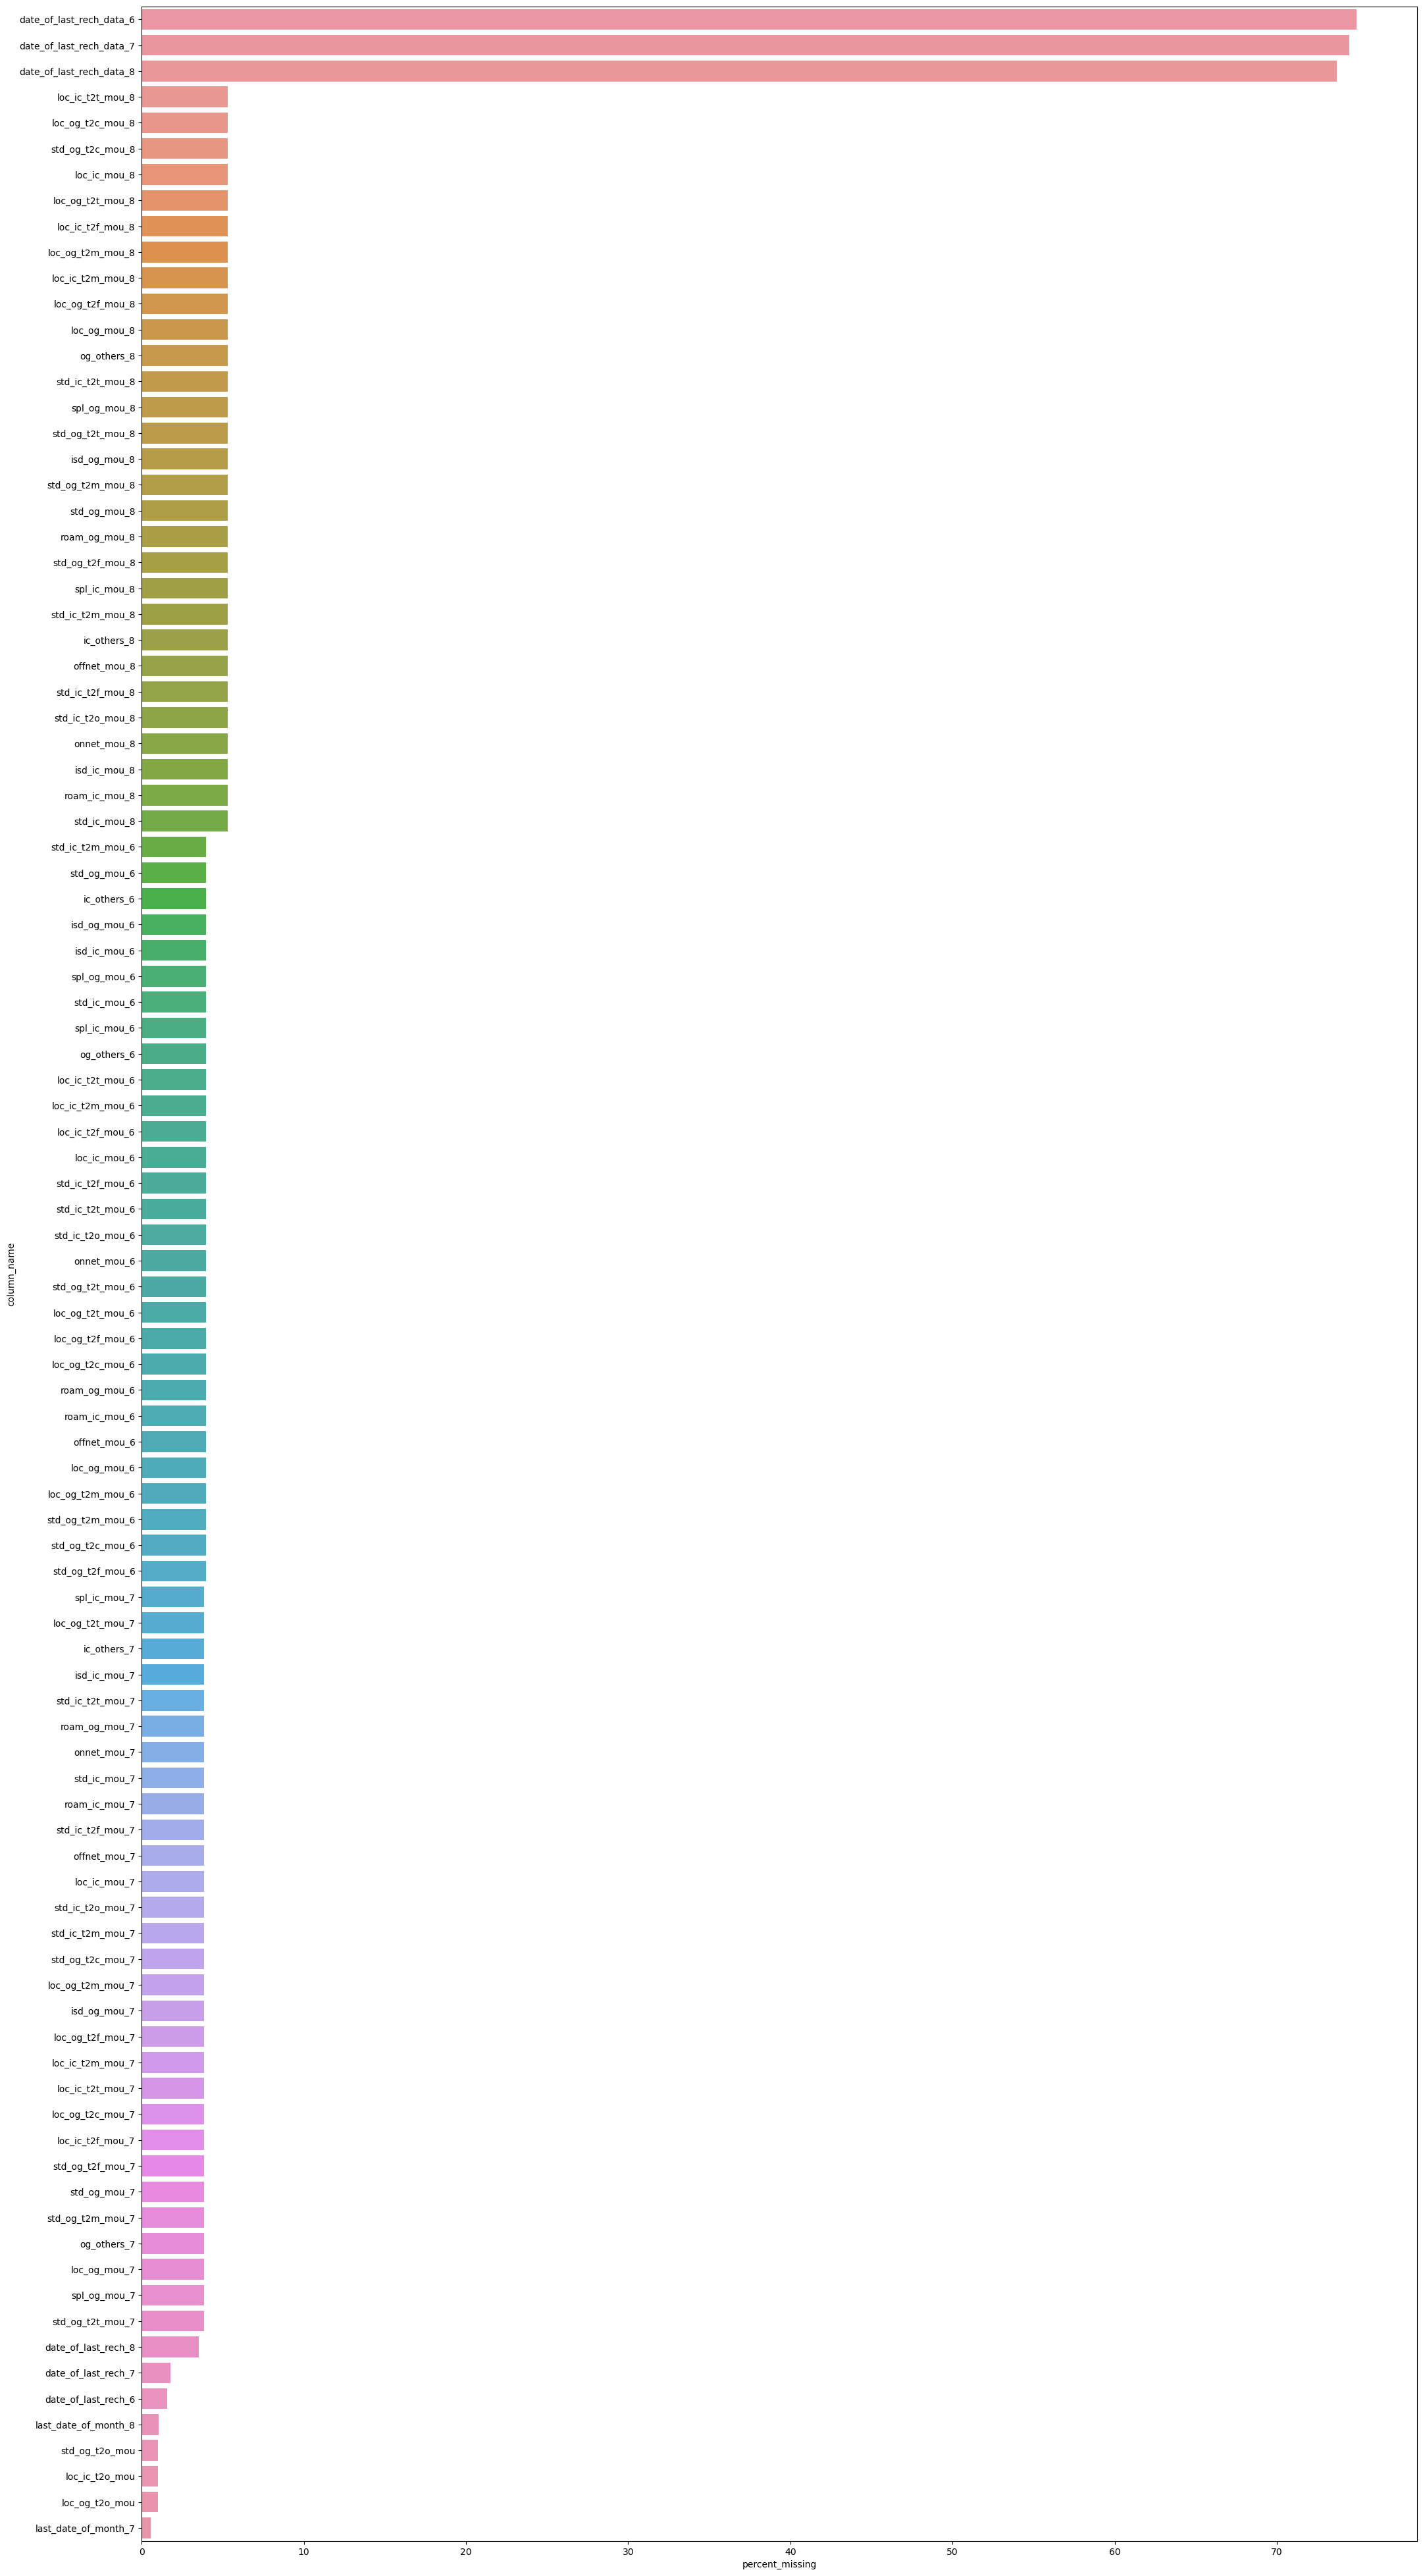

In [115]:
# check null value
plot_missing_values(df_train,25,50)



In [116]:
# impute the stats columns 
interesting_columns = ['loc_og_t2c_mou','std_ic_t2t_mou','loc_og_t2t_mou','loc_og_t2m_mou',
                       'std_ic_t2f_mou','loc_og_t2f_mou','std_ic_t2m_mou','loc_og_mou',
                       'std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_ic_t2o_mou',
                       'std_og_t2c_mou','std_og_mou','loc_ic_mou','isd_og_mou',
                       'spl_og_mou','og_others','loc_ic_t2f_mou','loc_ic_t2m_mou',
                       'roam_og_mou','loc_ic_t2t_mou','spl_ic_mou','ic_others',
                       'roam_ic_mou','onnet_mou','isd_ic_mou','offnet_mou','std_ic_mou']

impute_columns(df_train,imputes=interesting_columns)
impute_columns(df_test,imputes=interesting_columns)

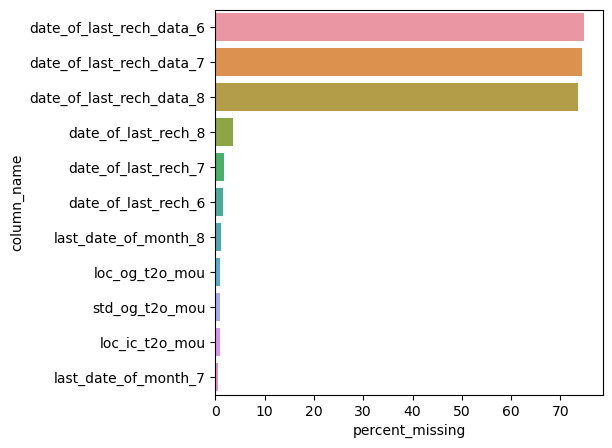

In [117]:
# check null value
plot_missing_values(df_train,5,5)


> date column treatment

In [118]:

last_day_data_columns = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
df_train[df_train['date_of_last_rech_data_6'].isnull()]['date_of_last_rech_data_6'] = '6/30/2014'
df_train[df_train['date_of_last_rech_data_7'].isnull()]['date_of_last_rech_data_7'] = '7/31/2014'
df_train[df_train['date_of_last_rech_data_8'].isnull()]['date_of_last_rech_data_8'] = '8/31/2014'

df_test[df_test['date_of_last_rech_data_6'].isnull()]['date_of_last_rech_data_6'] = '6/30/2014'
df_test[df_test['date_of_last_rech_data_7'].isnull()]['date_of_last_rech_data_7'] = '7/31/2014'
df_test[df_test['date_of_last_rech_data_8'].isnull()]['date_of_last_rech_data_8'] = '8/31/2014'


> check values for uniqueness

In [119]:

unique_value_columns = ['last_date_of_month_8','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_7']
for col in unique_value_columns:
    print(df_train[col].unique())
    

['8/31/2014' nan]
[ 0. nan]
[ 0. nan]
[ 0. nan]
['7/31/2014' nan]


In [120]:
for col in unique_value_columns:
    print(df_test[col].unique())

['8/31/2014' nan]
[ 0. nan]
[ 0. nan]
[ 0. nan]
['7/31/2014' nan]


In [121]:
for col in unique_value_columns:
   df_train.fillna(df_train[col].mode()[0],inplace=True)
   df_test.fillna(df_test[col].mode()[0],inplace=True)

In [122]:
plot_missing_values(df_train,5,5)
df_train.shape

No data available


(69999, 172)

In [123]:
plot_missing_values(df_test,5,5)
df_test.shape

No data available


(30000, 171)

> Find Columns with Single Values  and drop them as they are not useful

In [124]:

single_valued_columns = df_train.columns[df_train.nunique() <= 1]
single_valued_columns

Index(['circle_id', 'last_date_of_month_6', 'last_date_of_month_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

In [125]:
single_value_drop_columns = ['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
                             'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','circle_id']
df_train.drop(single_value_drop_columns,axis=1,inplace=True)
df_test.drop(single_value_drop_columns,axis=1,inplace=True)

In [126]:
df_train.shape

(69999, 165)

In [127]:
len(df_train.id.value_counts())
#remove id
df_train.drop(['id'],axis=1,inplace=True)

In [128]:
df_train.reset_index(inplace=True,drop=True)

df_test.reset_index(inplace=True,drop=True)
df_test.shape

(30000, 164)

In [129]:
df_train.shape

(69999, 164)

> Format Date Columns

In [130]:

dates = list(df_train.filter(regex='date').columns)
dates

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [131]:
for date_column in dates:
    df_train[date_column] = pd.to_datetime(df_train[date_column], format='%m/%d/%Y')
    df_test[date_column] = pd.to_datetime(df_test[date_column], format='%m/%d/%Y')

>  Find and drop object columns

In [132]:
df_train.info()

for dtype_col in df_train.columns:
    if df_train[dtype_col].dtype == object:
        print(dtype_col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 164 entries, loc_og_t2o_mou to churn_probability
dtypes: datetime64[ns](9), float64(126), int64(26), object(3)
memory usage: 87.6+ MB
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou


In [133]:
df_train.loc_ic_t2o_mou.unique()
object_columns = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou']
df_train.drop(object_columns,axis=1,inplace=True)
df_test.drop(object_columns,axis=1,inplace=True)


In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 161 entries, last_date_of_month_6 to churn_probability
dtypes: datetime64[ns](9), float64(126), int64(26)
memory usage: 86.0 MB


> rename to conventional column names

In [135]:
unconventional_columns = list(df_train.filter(regex='vbc').columns)
unconventional_columns


['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [136]:

df_train.rename(columns={'aug_vbc_3g' : 'vbc_3g_8', 'jul_vbc_3g' : 'vbc_3g_7', 'jun_vbc_3g' : 'vbc_3g_6'}, inplace=True)
df_test.rename(columns={'aug_vbc_3g' : 'vbc_3g_8', 'jul_vbc_3g' : 'vbc_3g_7', 'jun_vbc_3g' : 'vbc_3g_6'}, inplace=True)


>  Check for Skewness

In [137]:

for col_name in df_train.columns:
    if (len(df_train[col_name].unique()) <= 8):
        print(df_train[col_name].value_counts())
        print(f"\n{35 * '-'}")

2014-06-30    69999
Name: last_date_of_month_6, dtype: int64

-----------------------------------
2014-07-31    69600
2014-08-31      399
Name: last_date_of_month_7, dtype: int64

-----------------------------------
2014-08-31    69999
Name: last_date_of_month_8, dtype: int64

-----------------------------------
0.0    69555
1.0      444
Name: night_pck_user_6, dtype: int64

-----------------------------------
0.0    69569
1.0      430
Name: night_pck_user_7, dtype: int64

-----------------------------------
0.0    69612
1.0      387
Name: night_pck_user_8, dtype: int64

-----------------------------------
0    64896
1     4688
2      389
3       20
4        6
Name: monthly_2g_6, dtype: int64

-----------------------------------
0    64695
1     4806
2      467
3       27
4        3
5        1
Name: monthly_2g_7, dtype: int64

-----------------------------------
0    64817
1     4738
2      413
3       24
4        6
5        1
Name: monthly_2g_8, dtype: int64

-------------------------

> Find Highly correlated data and drop Highly Correlated Columns

In [138]:
df_train_2 = df_train.copy()

cor = df_train_2.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values(ascending=False)


sachet_2g_8       count_rech_2g_8       0.983562
sachet_2g_7       count_rech_2g_7       0.983300
sachet_2g_6       count_rech_2g_6       0.980998
total_rech_amt_8  arpu_8                0.958333
total_rech_amt_7  arpu_7                0.955298
                                          ...   
arpu_3g_7         vol_3g_mb_8           0.603865
total_og_mou_7    onnet_mou_8           0.603600
vol_3g_mb_7       av_rech_amt_data_6    0.602328
offnet_mou_7      arpu_7                0.600463
monthly_3g_7      max_rech_data_7       0.600074
Length: 304, dtype: float64

## PCA

In [140]:

# drop the dates field
df_train.drop(dates,axis=1,inplace=True)


KeyError: "['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'] not found in axis"

In [141]:
df_test.drop(dates,axis=1,inplace=True)

In [142]:
print("Train:{0} \nTest:{1}".format(df_train.shape,df_test.shape))

Train:(69999, 152) 
Test:(30000, 152)


In [143]:
df_3 = df_train_2.select_dtypes(exclude=['datetime64'])
df_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 152 entries, arpu_6 to churn_probability
dtypes: float64(126), int64(26)
memory usage: 81.2 MB


In [144]:

X = df_3.drop(['churn_probability'], axis=1)
y = df_3['churn_probability']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

df_4 = df_test.select_dtypes(exclude=['datetime64'])
X1_test = df_4.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)



In [145]:
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(88086, 151)
(88086,)


In [146]:

#Improting the PCA module
pca = PCA(random_state=100)

#Doing the PCA on the train data
pca.fit(X_tr)

X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)


(88086, 151)
(21000, 151)


In [147]:
print(y_train.shape)

(48999,)


In [148]:
print(y_test.shape)

(21000,)


#### Create Copies

In [149]:

X_tr_pca_1 = X_tr_pca.copy()
X_test_pca_1 = X_test_pca.copy()

X_tr_pca_2 = X_tr_pca.copy()
X_test_pca_2 = X_test_pca.copy()

X_tr_pca_3 = X_tr_pca.copy()
X_test_pca_3 = X_test_pca.copy()

In [150]:
# Create Model for Logistic Regression
lr_pca = LogisticRegression(max_iter=500)
lr_pca.fit(X_tr_pca, y_tr)


LogisticRegression(max_iter=500)

In [151]:

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [152]:

conf_mat = confusion_matrix(y_test,y_pred)
print(conf_mat)

[[15114  3710]
 [  326  1850]]


In [153]:
model_metrics(conf_mat)



Accuracy : 0.808
Sensitivity / True Positive Rate / Recall : 0.85
Specificity / True Negative Rate :  0.803
Precision / Positive Predictive Value : 0.333
F1-score : 0.479


In [154]:

print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred))

Logistic Regression accuracy with PCA:  0.8078095238095238


In [155]:
df_5=df_3.copy()
df_5.drop('churn_probability', axis=1,inplace=True)
col = list(df_5.columns)
df_pca = pd.DataFrame({'PCA1':pca.components_[0],'PCA2':pca.components_[1], 'PCA3':pca.components_[2],'Feature':col})
df_pca.head(10)



,PCA1,PCA2,PCA3,Feature
0,0.163211,-0.086181,-0.059417,arpu_6
1,0.181882,-0.075450,-0.040518,arpu_7
2,0.161489,-0.046654,0.005536,arpu_8
3,0.091741,-0.148880,-0.103987,onnet_mou_6
4,0.101559,-0.138148,-0.088491,onnet_mou_7
5,0.088558,-0.098256,-0.039160,onnet_mou_8
6,0.125047,-0.154646,-0.061930,offnet_mou_6
7,0.133780,-0.140438,-0.043555,offnet_mou_7
8,0.111309,-0.092124,0.005594,offnet_mou_8
9,0.015953,-0.012988,-0.014545,roam_ic_mou_6


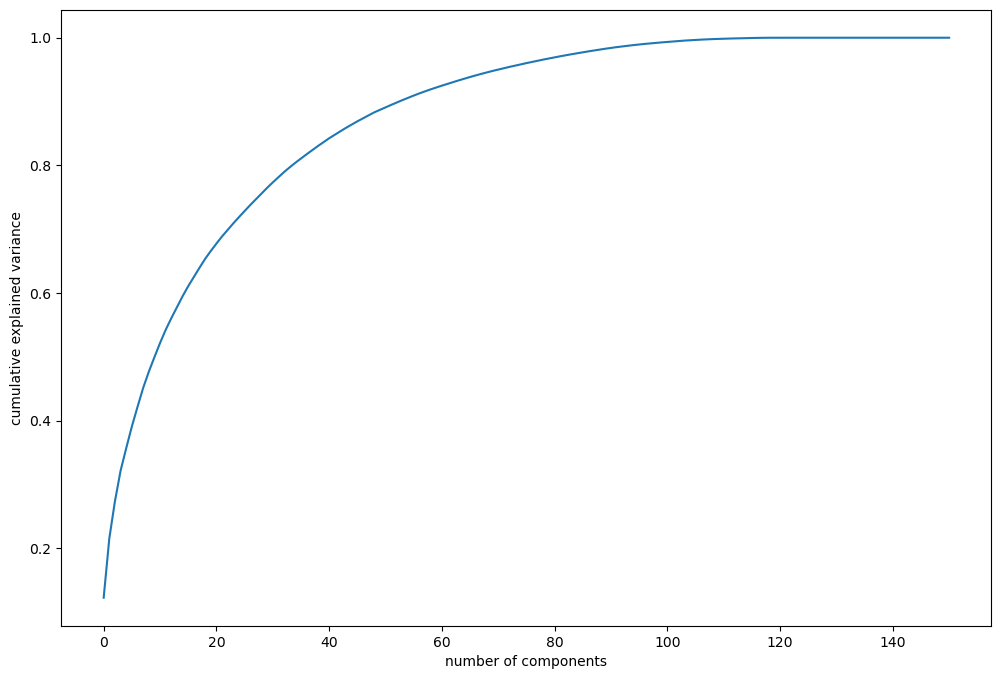

In [156]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [157]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([12.23, 21.53, 27.36, 32.13, 35.66, 39.06, 42.12, 45.09, 47.63,
       49.92, 52.15, 54.21, 56.04, 57.78, 59.49, 61.07, 62.52, 63.95,
       65.34, 66.57, 67.73, 68.86, 69.9 , 70.91, 71.89, 72.84, 73.78,
       74.69, 75.6 , 76.48, 77.33, 78.15, 78.95, 79.69, 80.4 , 81.07,
       81.73, 82.38, 83.01, 83.63, 84.23, 84.79, 85.34, 85.88, 86.39,
       86.89, 87.36, 87.83, 88.29, 88.69, 89.08, 89.47, 89.85, 90.22,
       90.58, 90.93, 91.27, 91.59, 91.9 , 92.2 , 92.49, 92.77, 93.05,
       93.32, 93.59, 93.85, 94.1 , 94.34, 94.57, 94.8 , 95.02, 95.23,
       95.43, 95.63, 95.83, 96.02, 96.21, 96.39, 96.57, 96.74, 96.91,
       97.08, 97.25, 97.4 , 97.55, 97.7 , 97.85, 97.99, 98.13, 98.26,
       98.39, 98.51, 98.62, 98.73, 98.83, 98.93, 99.02, 99.1 , 99.18,
       99.25, 99.32, 99.39, 99.46, 99.52, 99.58, 99.63, 99.68, 99.72,
       99.76, 99.79, 99.82, 99.85, 99.87, 99.89, 99.91, 99.93, 99.95,
       99.97, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98, 99.98,
       99.98, 99.98,

In [158]:
pca_54 = PCA(n_components=54)

df_tr_pca_54 = pca_54.fit_transform(X_tr)
print(df_tr_pca_54.shape)

df_test_pca_54 = pca_54.transform(X_test)
print(df_test_pca_54.shape)

(88086, 54)
(21000, 54)


In [159]:
# Let's run the model using the selected variables
lr_pca1 = LogisticRegression(max_iter=500)
lr_pca1.fit(df_tr_pca_54, y_tr)

# Predicted probabilities
y_pred54 = lr_pca1.predict(df_test_pca_54)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred54)

conf_matrices = confusion_matrix(y_test,y_pred54)

model_metrics(conf_matrices)

Accuracy : 0.795
Sensitivity / True Positive Rate / Recall : 0.839
Specificity / True Negative Rate :  0.79
Precision / Positive Predictive Value : 0.316
F1-score : 0.459


In [160]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred54))

Logistic Regression accuracy with PCA:  0.7954285714285714


In [161]:
# Tuning hyper parameters 
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_tr_pca_1, y_tr)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [163]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.054263,0.049375,0.012365,0.001702,0.01,{'C': 0.01},0.873918,0.873052,0.871137,0.877510,0.875199,0.874163,0.002132,6,0.875223,0.875217,0.875262,0.874691,0.875273,0.875133,0.000222
1,1.179328,0.034715,0.011774,0.000896,0.1,{'C': 0.1},0.874829,0.873391,0.872391,0.878750,0.875655,0.875003,0.002187,5,0.876329,0.876211,0.875971,0.875373,0.875812,0.875939,0.000336
2,1.172776,0.039273,0.012117,0.001142,1,{'C': 1},0.875057,0.873616,0.872848,0.878525,0.875883,0.875186,0.001979,2,0.876556,0.876211,0.875829,0.875657,0.875925,0.876036,0.000316
3,1.184089,0.100259,0.011724,0.000971,10,{'C': 10},0.874601,0.873278,0.872733,0.878750,0.875997,0.875072,0.002159,3,0.876670,0.876297,0.875631,0.875515,0.876350,0.876093,0.000444
4,1.147816,0.025295,0.011429,0.000471,100,{'C': 100},0.874487,0.873391,0.872733,0.878976,0.875655,0.875049,0.002201,4,0.876528,0.876268,0.875744,0.875288,0.876209,0.876007,0.000440
5,1.137162,0.013208,0.011534,0.000638,1000,{'C': 1000},0.874715,0.873616,0.873076,0.878976,0.875655,0.875208,0.002084,1,0.876443,0.876126,0.875716,0.875572,0.876294,0.876030,0.000334


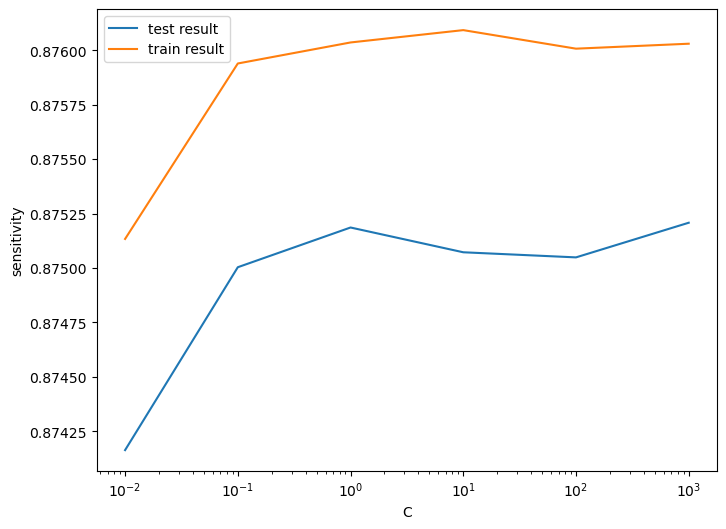

In [164]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [165]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))


 The highest test sensitivity is 0.8752077043883979 at C = 1000


#### Logistic regression with optimal C


In [166]:


# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_tr_pca_1, y_tr)

# Predictions on the train set
y_train_pred = log_pca_model.predict(X_tr_pca_1)

# Confusion matrix
confusion = metrics.confusion_matrix(y_tr, y_train_pred)
model_metrics(confusion)

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
model_metrics(confusion)

Accuracy : 0.837
Sensitivity / True Positive Rate / Recall : 0.876
Specificity / True Negative Rate :  0.798
Precision / Positive Predictive Value : 0.812
F1-score : 0.843
Accuracy : 0.808
Sensitivity / True Positive Rate / Recall : 0.85
Specificity / True Negative Rate :  0.803
Precision / Positive Predictive Value : 0.332
F1-score : 0.477


### Random Forest

In [167]:


# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
#forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1, random_state=42)
forest = RandomForestClassifier(random_state=42, 
                                class_weight= {0:0.1, 1: 0.9},
                                oob_score=True, n_jobs=-1,verbose=1)


In [168]:
# hyperparameter space
params = {  'max_depth': [3,4,5,6,7],
            'min_samples_leaf': [5,10,25,30],
            'n_estimators': [30, 40, 50, 100]
         }

# create folds
folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


In [169]:
# fit model= Runs for 22 minutes 
model.fit(X_tr_pca_2, y_tr)


Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [5, 10, 25, 30],
                         'n_estimators': [30, 40, 50, 100]},
             scoring='roc_auc', verbose=1)

In [170]:
# Optimum Hyperparameters
print('Best ROC-AUC score :', model.best_score_)
print('Best Parameters :', model.best_params_)

Best ROC-AUC score : 0.933213043790105
Best Parameters : {'max_depth': 7, 'min_samples_leaf': 5, 'n_estimators': 100}


In [171]:

# Modelling using the best PCA-RandomForest Estimator 
pca_rf_best = model.best_estimator_
pca_rf_best_fit = pca_rf_best.fit(X_tr_pca_2, y_tr)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


In [172]:
X_tr_pca_2.shape

(88086, 151)

In [173]:
y_tr.shape

(88086,)

In [174]:

# Prediction on Train set
y_train_pred_pca_rf_best = pca_rf_best_fit.predict(X_tr_pca_2)
y_train_pred_pca_rf_best[:5]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


array([0, 1, 0, 0, 1])

In [175]:
# Prediction on test set
y_test_pred_pca_rf_best = pca_rf_best_fit.predict(X_test_pca_2)
y_test_pred_pca_rf_best[:5]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


array([1, 1, 1, 1, 1])

In [176]:

train_matrix = confusion_matrix(y_tr, y_train_pred_pca_rf_best)
test_matrix = confusion_matrix(y_test, y_test_pred_pca_rf_best)

print('Train Performance :\n')
model_metrics(train_matrix)

print('\nTest Performance :\n')
model_metrics(test_matrix)

Train Performance :

Accuracy : 0.559
Sensitivity / True Positive Rate / Recall : 1.0
Specificity / True Negative Rate :  0.118
Precision / Positive Predictive Value : 0.531
F1-score : 0.694

Test Performance :

Accuracy : 0.203
Sensitivity / True Positive Rate / Recall : 0.996
Specificity / True Negative Rate :  0.112
Precision / Positive Predictive Value : 0.115
F1-score : 0.206


In [177]:
## out of bag error 
pca_rf_best_fit.oob_score_

0.5588061667007242

In [178]:
y_tr.shape


(88086,)

#### Using XGboost

In [179]:
# Ratio of classes 
class_0 = y_tr[y_tr == 0].count()
class_1 = y_tr[y_tr == 1].count()
print("Ratio of classes {0}:{1}".format(class_0,class_1))

Ratio of classes 44043:44043


In [180]:
pca_xgb = xgb.XGBClassifier(random_state=42, 
                            scale_pos_weight= class_0/class_1 ,
                            tree_method='hist', 
                            objective='binary:logistic',
                           )  # scale_pos_weight takes care of class imbalance
pca_xgb.fit(X_tr_pca_3, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [181]:
X_test_pca_3.shape

(21000, 151)

In [182]:
X_tr_pca_3.shape

(88086, 151)

In [183]:
print('Baseline Train AUC Score')
roc_auc_score(y_tr, pca_xgb.predict_proba(X_tr_pca_3)[:, 1])


Baseline Train AUC Score


0.9966872144658068

In [184]:

print('Baseline Test AUC Score')
roc_auc_score(y_test, pca_xgb.predict_proba(X_test_pca_3)[:, 1])


Baseline Test AUC Score


0.8931467387143447

In [185]:
## Hyper parameter Tuning
# Runs for 15 min
parameters = {
              'learning_rate': [0.1, 0.2],
              'gamma' : [10,20,50],
              'max_depth': [2,3,4],
              'min_child_weight': [25,50],
              'n_estimators': [150,200]}
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
pca_xgb_search = GridSearchCV(estimator=pca_xgb , param_grid=parameters,scoring='roc_auc', cv=folds, n_jobs=-1, verbose=1)
pca_xgb_search.fit(X_tr_pca_3, y_tr)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [10, 20, 50], 'learning_rate': [0.1, 0.2],
                         'max_depth': [2, 3, 4], 'min_child_weight': [25, 50],
                         'n_estimators': [150, 200]},
             scoring='roc_auc', verbose=1)

In [79]:
# Optimum Hyperparameters
print('Best ROC-AUC score :', pca_xgb_search.best_score_)
print('Best Parameters :', pca_xgb_search.best_params_)


Best ROC-AUC score : 0.9691282815845229
Best Parameters : {'gamma': 10, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 25, 'n_estimators': 200}


In [80]:
# Modelling using the best PCA-XGBoost Estimator 
pca_xgb_best = pca_xgb_search.best_estimator_
pca_xgb_best_fit = pca_xgb_best.fit(X_tr_pca_3, y_tr)

# Prediction on Train set
y_train_pred_pca_xgb_best = pca_xgb_best_fit.predict(X_tr_pca_3)
y_train_pred_pca_xgb_best[:5]



array([0, 0, 0, 0, 1])

In [186]:
# Prediction on test set
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)
y_test_pred_pca_xgb_best = pca_xgb_best_fit.predict(X_test_pca)
y_test_pred_pca_xgb_best[:5]



array([0, 1, 0, 1, 0])

In [187]:
## PCA - XGBOOST [Hyper parameter tuned] Model Performance

train_matrix = confusion_matrix(y_tr, y_train_pred_pca_xgb_best)
test_matrix = confusion_matrix(y_test, y_test_pred_pca_xgb_best)

print('Train Performance :\n')
model_metrics(train_matrix)

print('\nTest Performance :\n')
model_metrics(test_matrix)


Train Performance :

Accuracy : 0.938
Sensitivity / True Positive Rate / Recall : 0.947
Specificity / True Negative Rate :  0.929
Precision / Positive Predictive Value : 0.93
F1-score : 0.938

Test Performance :

Accuracy : 0.884
Sensitivity / True Positive Rate / Recall : 0.655
Specificity / True Negative Rate :  0.91
Precision / Positive Predictive Value : 0.457
F1-score : 0.538


#### Recommendations
##### Best Model is Xg Boost

In [188]:
df_test.shape


(30000, 152)

In [190]:

df_id = df_test[["id"]]
df_test.pop("id")
y_test_pred_pca_xgb_best_sample = pca_xgb_best_fit.predict(df_test)
df_sample_test = pd.DataFrame(y_test_pred_pca_xgb_best_sample)
df_sample_test.columns =['churn_prob']
df_sample_test.head()
df_sample_test.isnull().values.any()

False

In [191]:
df_id.head()


,id
0,69999
1,70000
2,70001
3,70002
4,70003


In [192]:

frames = [df_id, df_sample_test]
frames


[          id
 0      69999
 1      70000
 2      70001
 3      70002
 4      70003
 ...      ...
 29995  99994
 29996  99995
 29997  99996
 29998  99997
 29999  99998
 
 [30000 rows x 1 columns],
        churn_prob
 0               1
 1               1
 2               1
 3               1
 4               0
 ...           ...
 29995           1
 29996           1
 29997           1
 29998           1
 29999           0
 
 [30000 rows x 1 columns]]

In [199]:

result = pd.concat(frames,axis=1)
result.to_csv("Submission.csv")
